In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytz
from pytz import all_timezones

In [2]:
folder = "./ASEAN_2018D"
movements_2018_1 = pd.read_csv(filepath_or_buffer = folder + "/ASEAN_2018D_Jan_Mar_JobId2081527.csv", sep = ",", header = 0)
movements_2018_2 = pd.read_csv(filepath_or_buffer = folder + "/ASEAN_2018D_Apr_Jun_JobId2081525.csv", sep = ",", header = 0)
movements_2018_3 = pd.read_csv(filepath_or_buffer = folder + "/ASEAN_2018D_Jul_Sep_JobId2081528.csv", sep = ",", header = 0)
movements_2018_4 = pd.read_csv(filepath_or_buffer = folder + "/ASEAN_2018D_Oct_Dec_JobId2081529.csv", sep = ",", header = 0)
movements_2018 = pd.concat([movements_2018_1, movements_2018_2, movements_2018_3, movements_2018_4])

folder = "./ASEAN_2019D"
movements_2019_1 = pd.read_csv(filepath_or_buffer = folder + "/ASEAN_2019D_Jan_Mar_JobId2082476.csv", sep = ",", header = 0)
movements_2019_2 = pd.read_csv(filepath_or_buffer = folder + "/ASEAN_2019D_Apr_Jun_JobId2081531.csv", sep = ",", header = 0)
movements_2019_3 = pd.read_csv(filepath_or_buffer = folder + "/ASEAN_2019D_Jul_Sep_JobId2081532.csv", sep = ",", header = 0)
movements_2019_4 = pd.read_csv(filepath_or_buffer = folder + "/ASEAN_2019D_Oct_Dec_JobId2082477.csv", sep = ",", header = 0)
movements_2019 = pd.concat([movements_2019_1, movements_2019_2, movements_2019_3, movements_2019_4])

movements_all = pd.concat([movements_2018, movements_2019])

In [3]:
def dep_value(s):
    if s == 'SIN':
        return 1
    else:
        return 0
    
def arr_value(s):
    if s == 'SIN':
        return 1
    else:
        return 0

In [4]:
def dep_or_arr_time(dep, dep_time, arr_time):
    if dep == 1:
        return dep_time
    else:
        return arr_time

In [5]:
def f(s):
    return "".join(["0"]*(4-len(s))) + s

In [6]:
def utc(datetime):
    local = pytz.timezone("Asia/Singapore")
    local_dt = local.localize(datetime, is_dst=None)
    return local_dt.astimezone(pytz.utc)

In [7]:
def day_of_week(s):
    return s.weekday()

In [8]:
def requested_utc_hour(s):
    return s.hour

def requested_utc_minute(s):
    if s.minute == 0:
        return "00"
    elif s.minute == 5:
        return "05"
    else:
        return s.minute

In [9]:
movements_Dep_SIN = movements_all.loc[movements_all['Dep Airport Code'] == 'SIN']
movements_Arr_SIN = movements_all.loc[movements_all['Arr Airport Code'] == 'SIN']
movements_SIN = pd.concat([movements_Dep_SIN, movements_Arr_SIN])

In [10]:
movements_SIN['Dep'] = 0
movements_SIN['Arr'] = 0

movements_SIN['Dep'] = movements_SIN['Dep Airport Code'].apply(dep_value)
movements_SIN['Arr'] = movements_SIN['Arr Airport Code'].apply(arr_value)

In [11]:
movements_SIN['Time_requested'] = movements_SIN[['Dep', 'Local Dep Time', 'Local Arr Time']].apply(lambda x: dep_or_arr_time(*x), axis=1)
movements_SIN = movements_SIN.drop(['Dep Airport Code', 'Arr Airport Code'], 1)

In [12]:
movements_SIN['Time_requested_format4'] = movements_SIN['Time_requested'].astype(str).apply(f)
movements_SIN['Time_requested_TS'] = movements_SIN['Time series'] + '-' + movements_SIN['Time_requested_format4']
movements_SIN['TS_datetime_format'] = pd.to_datetime(movements_SIN['Time_requested_TS'], format = '%Y-%m-%d-%H%M')

In [13]:
movements_SIN['Time_requested_UTC'] = movements_SIN['TS_datetime_format'].apply(utc)

In [14]:
movements_SIN['day_of_week'] = movements_SIN['Time_requested_UTC'].apply(day_of_week)
movements_SIN['Time_series_DT'] = pd.to_datetime(movements_SIN['Time_requested_UTC']).dt.date

In [15]:
# sort by date
movements_SIN.sort_values(by=['Time_series_DT'], inplace=True)
#movements_SIN

In [16]:
movements_SIN['requested_utc_hour'] = movements_SIN['Time_requested_UTC'].apply(requested_utc_hour)
movements_SIN['requested_utc_minute'] = movements_SIN['Time_requested_UTC'].apply(requested_utc_minute)
movements_SIN['requested_utc'] = movements_SIN['requested_utc_hour'].apply(str) + movements_SIN['requested_utc_minute'].apply(str)
movements_SIN['requested_utc'] = movements_SIN['requested_utc'].astype(int)

In [17]:
time_slots = []
h = 0
m = 0
while h < 2400:
    while m < 60:
        time_slots.append(h + m)
        m = m + 5
    m = 0
    h = h + 100
time_slots.append(2400)

In [18]:
movements_SIN['Time slot'] = pd.cut(movements_SIN['requested_utc'], time_slots, right=False)

In [19]:
movements_SIN

,Dep Airport Name,Arr Airport Name,ICAO AL,IATA AL,Flight No,Carrier Code,Carrier Name,Dep IATA Country Name,Arr IATA Country Name,International/Domestic,...,Time_requested_format4,Time_requested_TS,TS_datetime_format,Time_requested_UTC,day_of_week,Time_series_DT,requested_utc_hour,requested_utc_minute,requested_utc,Time slot
755557,Singapore Changi Apt,Taipei Taiwan Taoyuan International Apt,TGW,TR,898,TR,Scoot,Singapore,Chinese Taipei,International,...,0055,2018-01-01-0055,2018-01-01 00:55:00,2017-12-31 16:55:00+00:00,6,2017-12-31,16,55,1655,"[1655, 1700)"
763163,Singapore Changi Apt,Zurich Airport,SIA,SQ,346,SQ,Singapore Airlines,Singapore,Switzerland,International,...,0130,2018-01-01-0130,2018-01-01 01:30:00,2017-12-31 17:30:00+00:00,6,2017-12-31,17,30,1730,"[1730, 1735)"
719601,Singapore Changi Apt,Kuala Lumpur International Airport,SLK,MI,322,MI,SilkAir,Singapore,Malaysia,International,...,0710,2018-01-01-0710,2018-01-01 07:10:00,2017-12-31 23:10:00+00:00,6,2017-12-31,23,10,2310,"[2310, 2315)"
189452,Bandaranaike Intl,Singapore Changi Apt,ALK,UL,306,UL,Srilankan Airlines,Sri Lanka,Singapore,International,...,0730,2018-01-01-0730,2018-01-01 07:30:00,2017-12-31 23:30:00+00:00,6,2017-12-31,23,30,2330,"[2330, 2335)"
763324,Singapore Changi Apt,Manila Ninoy Aquino International Apt,JSA,3K,763,3K,Jetstar Asia,Singapore,Philippines,International,...,0220,2018-01-01-0220,2018-01-01 02:20:00,2017-12-31 18:20:00+00:00,6,2017-12-31,18,20,1820,"[1820, 1825)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199059,Singapore Changi Apt,Manila Ninoy Aquino International Apt,CEB,5J,806,5J,Cebu Pacific Air,Singapore,Philippines,International,...,1900,2019-12-31-1900,2019-12-31 19:00:00,2019-12-31 11:00:00+00:00,1,2019-12-31,11,00,1100,"[1100, 1105)"
32840,Perth,Singapore Changi Apt,SIA,SQ,214,SQ,Singapore Airlines,Australia,Singapore,International,...,2240,2019-12-31-2240,2019-12-31 22:40:00,2019-12-31 14:40:00+00:00,1,2019-12-31,14,40,1440,"[1440, 1445)"
320655,Singapore Changi Apt,Hong Kong International Apt,SIA,SQ,856,SQ,Singapore Airlines,Singapore,Hong Kong (sar) China,International,...,0955,2019-12-31-0955,2019-12-31 09:55:00,2019-12-31 01:55:00+00:00,1,2019-12-31,1,55,155,"[155, 200)"
19140,Kuala Lumpur International Airport,Singapore Changi Apt,MXD,OD,801,OD,Malindo Airways,Malaysia,Singapore,International,...,0915,2019-12-31-0915,2019-12-31 09:15:00,2019-12-31 01:15:00+00:00,1,2019-12-31,1,15,115,"[115, 120)"


In [20]:
SIN_2018_s = movements_SIN[movements_SIN['Time_series_DT'] < pd.Timestamp(2018,10,28)]
SIN_2018_s = SIN_2018_s[SIN_2018_s['Time_series_DT'] > pd.Timestamp(2018,3,31)]

SIN_2018_w = movements_SIN[movements_SIN['Time_series_DT'] < pd.Timestamp(2019,3,31)]
SIN_2018_w = SIN_2018_w[SIN_2018_w['Time_series_DT'] > pd.Timestamp(2018,10,27)]

SIN_2019_s = movements_SIN[movements_SIN['Time_series_DT'] < pd.Timestamp(2019,10,27)]
SIN_2019_s = SIN_2019_s[SIN_2019_s['Time_series_DT'] > pd.Timestamp(2019,3,30)]

In [21]:
SIN_2019_s

,Dep Airport Name,Arr Airport Name,ICAO AL,IATA AL,Flight No,Carrier Code,Carrier Name,Dep IATA Country Name,Arr IATA Country Name,International/Domestic,...,Time_requested_format4,Time_requested_TS,TS_datetime_format,Time_requested_UTC,day_of_week,Time_series_DT,requested_utc_hour,requested_utc_minute,requested_utc,Time slot
792973,Singapore Changi Apt,Osaka Kansai International Airport,SIA,SQ,622,SQ,Singapore Airlines,Singapore,Japan,International,...,1355,2019-03-31-1355,2019-03-31 13:55:00,2019-03-31 05:55:00+00:00,6,2019-03-31,5,55,555,"[555, 600)"
706716,Singapore Changi Apt,Nagoya Chubu Centrair International Apt,SIA,SQ,672,SQ,Singapore Airlines,Singapore,Japan,International,...,0120,2019-04-01-0120,2019-04-01 01:20:00,2019-03-31 17:20:00+00:00,6,2019-03-31,17,20,1720,"[1720, 1725)"
257499,Singapore Changi Apt,Ko Samui,SLK,MI,774,MI,SilkAir,Singapore,Thailand,International,...,1025,2019-03-31-1025,2019-03-31 10:25:00,2019-03-31 02:25:00+00:00,6,2019-03-31,2,25,225,"[225, 230)"
638322,Taipei Taiwan Taoyuan International Apt,Singapore Changi Apt,JSA,3K,724,3K,Jetstar Asia,Chinese Taipei,Singapore,International,...,2015,2019-03-31-2015,2019-03-31 20:15:00,2019-03-31 12:15:00+00:00,6,2019-03-31,12,15,1215,"[1215, 1220)"
122118,Jakarta Soekarno-Hatta Apt,Singapore Changi Apt,LNI,JT,156,JT,Lion Air,Indonesia,Singapore,International,...,1900,2019-03-31-1900,2019-03-31 19:00:00,2019-03-31 11:00:00+00:00,6,2019-03-31,11,00,1100,"[1100, 1105)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355151,Brisbane,Singapore Changi Apt,SIA,SQ,246,SQ,Singapore Airlines,Australia,Singapore,International,...,0430,2019-10-27-0430,2019-10-27 04:30:00,2019-10-26 20:30:00+00:00,5,2019-10-26,20,30,2030,"[2030, 2035)"
708709,Bandung,Singapore Changi Apt,AWQ,QZ,365,QZ,Indonesia AirAsia,Indonesia,Singapore,International,...,1530,2019-10-26-1530,2019-10-26 15:30:00,2019-10-26 07:30:00+00:00,5,2019-10-26,7,30,730,"[730, 735)"
750273,Singapore Changi Apt,Ho Chi Minh City,JSA,3K,555,3K,Jetstar Asia,Singapore,Viet Nam,International,...,0710,2019-10-27-0710,2019-10-27 07:10:00,2019-10-26 23:10:00+00:00,5,2019-10-26,23,10,2310,"[2310, 2315)"
680901,Singapore Changi Apt,Kochi (IN),SLK,MI,468,MI,SilkAir,Singapore,India,International,...,2000,2019-10-26-2000,2019-10-26 20:00:00,2019-10-26 12:00:00+00:00,5,2019-10-26,12,00,1200,"[1200, 1205)"


In [22]:
SIN_2019_s['Time_series_DT'].unique()[0:7]

array([datetime.date(2019, 3, 31), datetime.date(2019, 4, 1),
       datetime.date(2019, 4, 2), datetime.date(2019, 4, 3),
       datetime.date(2019, 4, 4), datetime.date(2019, 4, 5),
       datetime.date(2019, 4, 6)], dtype=object)

In [23]:
# start here - example
first_week = SIN_2019_s['Time_series_DT'].unique()[0:7]
date = first_week[0]
SIN_2019_s_d1 = SIN_2019_s.loc[SIN_2019_s['Time_series_DT'] == date]
SIN_2019_s_d1

,Dep Airport Name,Arr Airport Name,ICAO AL,IATA AL,Flight No,Carrier Code,Carrier Name,Dep IATA Country Name,Arr IATA Country Name,International/Domestic,...,Time_requested_format4,Time_requested_TS,TS_datetime_format,Time_requested_UTC,day_of_week,Time_series_DT,requested_utc_hour,requested_utc_minute,requested_utc,Time slot
792973,Singapore Changi Apt,Osaka Kansai International Airport,SIA,SQ,622,SQ,Singapore Airlines,Singapore,Japan,International,...,1355,2019-03-31-1355,2019-03-31 13:55:00,2019-03-31 05:55:00+00:00,6,2019-03-31,5,55,555,"[555, 600)"
706716,Singapore Changi Apt,Nagoya Chubu Centrair International Apt,SIA,SQ,672,SQ,Singapore Airlines,Singapore,Japan,International,...,0120,2019-04-01-0120,2019-04-01 01:20:00,2019-03-31 17:20:00+00:00,6,2019-03-31,17,20,1720,"[1720, 1725)"
257499,Singapore Changi Apt,Ko Samui,SLK,MI,774,MI,SilkAir,Singapore,Thailand,International,...,1025,2019-03-31-1025,2019-03-31 10:25:00,2019-03-31 02:25:00+00:00,6,2019-03-31,2,25,225,"[225, 230)"
638322,Taipei Taiwan Taoyuan International Apt,Singapore Changi Apt,JSA,3K,724,3K,Jetstar Asia,Chinese Taipei,Singapore,International,...,2015,2019-03-31-2015,2019-03-31 20:15:00,2019-03-31 12:15:00+00:00,6,2019-03-31,12,15,1215,"[1215, 1220)"
122118,Jakarta Soekarno-Hatta Apt,Singapore Changi Apt,LNI,JT,156,JT,Lion Air,Indonesia,Singapore,International,...,1900,2019-03-31-1900,2019-03-31 19:00:00,2019-03-31 11:00:00+00:00,6,2019-03-31,11,00,1100,"[1100, 1105)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431791,Bangkok Suvarnabhumi International Apt,Singapore Changi Apt,SIA,SQ,977,SQ,Singapore Airlines,Thailand,Singapore,International,...,1855,2019-03-31-1855,2019-03-31 18:55:00,2019-03-31 10:55:00+00:00,6,2019-03-31,10,55,1055,"[1055, 1100)"
30053,Singapore Changi Apt,Penang,AXM,AK,1730,AK,AirAsia,Singapore,Malaysia,International,...,2140,2019-03-31-2140,2019-03-31 21:40:00,2019-03-31 13:40:00+00:00,6,2019-03-31,13,40,1340,"[1340, 1345)"
498502,Singapore Changi Apt,Tokyo Intl (Haneda),ANA,NH,842,NH,All Nippon Airways,Singapore,Japan,International,...,1100,2019-03-31-1100,2019-03-31 11:00:00,2019-03-31 03:00:00+00:00,6,2019-03-31,3,00,300,"[300, 305)"
73934,Singapore Changi Apt,Phuket,JSA,3K,537,3K,Jetstar Asia,Singapore,Thailand,International,...,2030,2019-03-31-2030,2019-03-31 20:30:00,2019-03-31 12:30:00+00:00,6,2019-03-31,12,30,1230,"[1230, 1235)"


In [24]:
def timeslot_to_index():
    # convert requested timeslot to index timeslot (eg. (0, 5] is slot 1)
    start = 0
    end = 5
    interval = pd.Interval(left=start, right=end, closed='left')

    # eg. (0, 5] -> slot 1
    interval_slot_dict = {} 

    for slot in range(1, 289, 1):
        interval_slot_dict[interval] = slot
        if (end % 100 == 55):
            start = interval.left + 5
            end = interval.right + 45
        elif (start % 100 == 55):
            start = interval.left + 45
            end = interval.right + 5
        else:
            start = interval.left + 5
            end = interval.right + 5

        interval = pd.Interval(left=start, right=end, closed='left')
        
    return interval_slot_dict

In [25]:
def get_first_week_dates(SIN_2019_s):
    first_week = SIN_2019_s['Time_series_DT'].unique()[0:7]
    return first_week # array with 1st week's dates

In [26]:
def get_first_week_df(SIN_2019_s, date): # date = first_week[0]
    SIN_2019_s_d1 = SIN_2019_s.loc[SIN_2019_s['Time_series_DT'] == date]
    return SIN_2019_s_d1 # df of a particualr day of the 1st week

In [27]:
def mov_per_slot(SIN_2019_s_d1, interval_slot_dict):
    timeslot_movements = SIN_2019_s_d1['Time slot'].value_counts(dropna=False)
    timeslot_movements = timeslot_movements.to_frame()
    timeslot_movements = timeslot_movements.rename({'Time slot': 'Movements'}, axis = 1)
    timeslot_movements = timeslot_movements.reset_index()
    
    timeslot_movements['Slot'] = ''
    for index, row in timeslot_movements.iterrows():
        row['Slot'] = interval_slot_dict.get(row['index'])
    
    timeslot_movements['Slot'] = timeslot_movements.apply(lambda row: interval_slot_dict.get(row['index']), axis=1)
    return timeslot_movements

In [28]:
# 1st day - 2019 summer
interval_slot_dict = timeslot_to_index()
first_week = get_first_week_dates(SIN_2019_s)
date = first_week[0]
SIN_2019_s_d1 = get_first_week_df(SIN_2019_s, date)
timeslot_movements = mov_per_slot(SIN_2019_s_d1, interval_slot_dict)
timeslot_movements

,index,Movements,Slot
0,"[1115, 1120)",11,136
1,"[745, 750)",9,94
2,"[30, 35)",9,7
3,"[850, 855)",9,107
4,"[855, 900)",9,108
...,...,...,...
283,"[2225, 2230)",0,270
284,"[1950, 1955)",0,239
285,"[1940, 1945)",0,237
286,"[1925, 1930)",0,234


In [29]:
SIN_2019_s_d1

,Dep Airport Name,Arr Airport Name,ICAO AL,IATA AL,Flight No,Carrier Code,Carrier Name,Dep IATA Country Name,Arr IATA Country Name,International/Domestic,...,Time_requested_format4,Time_requested_TS,TS_datetime_format,Time_requested_UTC,day_of_week,Time_series_DT,requested_utc_hour,requested_utc_minute,requested_utc,Time slot
792973,Singapore Changi Apt,Osaka Kansai International Airport,SIA,SQ,622,SQ,Singapore Airlines,Singapore,Japan,International,...,1355,2019-03-31-1355,2019-03-31 13:55:00,2019-03-31 05:55:00+00:00,6,2019-03-31,5,55,555,"[555, 600)"
706716,Singapore Changi Apt,Nagoya Chubu Centrair International Apt,SIA,SQ,672,SQ,Singapore Airlines,Singapore,Japan,International,...,0120,2019-04-01-0120,2019-04-01 01:20:00,2019-03-31 17:20:00+00:00,6,2019-03-31,17,20,1720,"[1720, 1725)"
257499,Singapore Changi Apt,Ko Samui,SLK,MI,774,MI,SilkAir,Singapore,Thailand,International,...,1025,2019-03-31-1025,2019-03-31 10:25:00,2019-03-31 02:25:00+00:00,6,2019-03-31,2,25,225,"[225, 230)"
638322,Taipei Taiwan Taoyuan International Apt,Singapore Changi Apt,JSA,3K,724,3K,Jetstar Asia,Chinese Taipei,Singapore,International,...,2015,2019-03-31-2015,2019-03-31 20:15:00,2019-03-31 12:15:00+00:00,6,2019-03-31,12,15,1215,"[1215, 1220)"
122118,Jakarta Soekarno-Hatta Apt,Singapore Changi Apt,LNI,JT,156,JT,Lion Air,Indonesia,Singapore,International,...,1900,2019-03-31-1900,2019-03-31 19:00:00,2019-03-31 11:00:00+00:00,6,2019-03-31,11,00,1100,"[1100, 1105)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431791,Bangkok Suvarnabhumi International Apt,Singapore Changi Apt,SIA,SQ,977,SQ,Singapore Airlines,Thailand,Singapore,International,...,1855,2019-03-31-1855,2019-03-31 18:55:00,2019-03-31 10:55:00+00:00,6,2019-03-31,10,55,1055,"[1055, 1100)"
30053,Singapore Changi Apt,Penang,AXM,AK,1730,AK,AirAsia,Singapore,Malaysia,International,...,2140,2019-03-31-2140,2019-03-31 21:40:00,2019-03-31 13:40:00+00:00,6,2019-03-31,13,40,1340,"[1340, 1345)"
498502,Singapore Changi Apt,Tokyo Intl (Haneda),ANA,NH,842,NH,All Nippon Airways,Singapore,Japan,International,...,1100,2019-03-31-1100,2019-03-31 11:00:00,2019-03-31 03:00:00+00:00,6,2019-03-31,3,00,300,"[300, 305)"
73934,Singapore Changi Apt,Phuket,JSA,3K,537,3K,Jetstar Asia,Singapore,Thailand,International,...,2030,2019-03-31-2030,2019-03-31 20:30:00,2019-03-31 12:30:00+00:00,6,2019-03-31,12,30,1230,"[1230, 1235)"


In [30]:
SIN_2019_s_d1 = SIN_2019_s_d1.reset_index()

In [32]:
interval_slot_dict = timeslot_to_index()
SIN_2019_s_d1['Slot'] = SIN_2019_s_d1.apply(lambda row: interval_slot_dict.get(row['Time slot']), axis=1)
SIN_2019_s_d1['Slot'] = SIN_2019_s_d1['Slot'].round().astype('Int64')
SIN_2019_s_d1

,index,Dep Airport Name,Arr Airport Name,ICAO AL,IATA AL,Flight No,Carrier Code,Carrier Name,Dep IATA Country Name,Arr IATA Country Name,...,Time_requested_TS,TS_datetime_format,Time_requested_UTC,day_of_week,Time_series_DT,requested_utc_hour,requested_utc_minute,requested_utc,Time slot,Slot
0,792973,Singapore Changi Apt,Osaka Kansai International Airport,SIA,SQ,622,SQ,Singapore Airlines,Singapore,Japan,...,2019-03-31-1355,2019-03-31 13:55:00,2019-03-31 05:55:00+00:00,6,2019-03-31,5,55,555,"[555, 600)",72
1,706716,Singapore Changi Apt,Nagoya Chubu Centrair International Apt,SIA,SQ,672,SQ,Singapore Airlines,Singapore,Japan,...,2019-04-01-0120,2019-04-01 01:20:00,2019-03-31 17:20:00+00:00,6,2019-03-31,17,20,1720,"[1720, 1725)",209
2,257499,Singapore Changi Apt,Ko Samui,SLK,MI,774,MI,SilkAir,Singapore,Thailand,...,2019-03-31-1025,2019-03-31 10:25:00,2019-03-31 02:25:00+00:00,6,2019-03-31,2,25,225,"[225, 230)",30
3,638322,Taipei Taiwan Taoyuan International Apt,Singapore Changi Apt,JSA,3K,724,3K,Jetstar Asia,Chinese Taipei,Singapore,...,2019-03-31-2015,2019-03-31 20:15:00,2019-03-31 12:15:00+00:00,6,2019-03-31,12,15,1215,"[1215, 1220)",148
4,122118,Jakarta Soekarno-Hatta Apt,Singapore Changi Apt,LNI,JT,156,JT,Lion Air,Indonesia,Singapore,...,2019-03-31-1900,2019-03-31 19:00:00,2019-03-31 11:00:00+00:00,6,2019-03-31,11,00,1100,"[1100, 1105)",133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,431791,Bangkok Suvarnabhumi International Apt,Singapore Changi Apt,SIA,SQ,977,SQ,Singapore Airlines,Thailand,Singapore,...,2019-03-31-1855,2019-03-31 18:55:00,2019-03-31 10:55:00+00:00,6,2019-03-31,10,55,1055,"[1055, 1100)",132
1053,30053,Singapore Changi Apt,Penang,AXM,AK,1730,AK,AirAsia,Singapore,Malaysia,...,2019-03-31-2140,2019-03-31 21:40:00,2019-03-31 13:40:00+00:00,6,2019-03-31,13,40,1340,"[1340, 1345)",165
1054,498502,Singapore Changi Apt,Tokyo Intl (Haneda),ANA,NH,842,NH,All Nippon Airways,Singapore,Japan,...,2019-03-31-1100,2019-03-31 11:00:00,2019-03-31 03:00:00+00:00,6,2019-03-31,3,00,300,"[300, 305)",37
1055,73934,Singapore Changi Apt,Phuket,JSA,3K,537,3K,Jetstar Asia,Singapore,Thailand,...,2019-03-31-2030,2019-03-31 20:30:00,2019-03-31 12:30:00+00:00,6,2019-03-31,12,30,1230,"[1230, 1235)",151


In [33]:
def one_hot_encode_airport(airport, num_airports):
    encoding = np.zeros(num_airports)
    encoding[airport] = 1
    return encoding

def use_scenario(SIN_2019_s_d1, num_airports):
    
    number_of_requests = len(SIN_2019_s_d1.index)
    ts_dep = SIN_2019_s_d1['Slot'].to_numpy() 

    #Generate index for requests:
    #index = np.array(list(range(number_of_requests)))
    index = SIN_2019_s_d1.index.to_numpy()

    origin_airport = np.empty(shape=(number_of_requests,), dtype='object')
    
    for i in range(number_of_requests):
        #Generate origin (0 and 1 are two considered origin airports, 2 represent other airports, encoded in one-hot vector):
        _org_airport = one_hot_encode_airport(0, num_airports)
        _org_airport_list = _org_airport.tolist()
        origin_airport[i] = _org_airport_list
       
    # Define requests_full as dtype object
    num_entries = len(index)  # Given that 'index' is defined using np.array(list(range(number_of_requests)))
    # Create an empty array of the desired shape with dtype=object
    requests_full = np.empty((num_entries, 3), dtype=object)
   
    data = [index, ts_dep, origin_airport]
    for i, column_data in enumerate(data):
        requests_full[:, i] = column_data

    return requests_full, number_of_requests

In [34]:
num_airports = 1
use_scenario(SIN_2019_s_d1, num_airports)

(array([[0, 72, list([1.0])],
        [1, 209, list([1.0])],
        [2, 30, list([1.0])],
        ...,
        [1054, 37, list([1.0])],
        [1055, 151, list([1.0])],
        [1056, 113, list([1.0])]], dtype=object),
 1057)

In [35]:
from pulp import *

num_airports = 1
#number_of_requests = 1000
flight_requests, number_of_requests = use_scenario(SIN_2019_s_d1, num_airports)
time_slots = 288 # Time slots and their characteristics
capacity_per_slot = 6
max_movements = 6 #19 
 
# Create a MILP problem
problem = LpProblem(name="Flight_Scheduling", sense=LpMinimize)

# Create binary decision variables for each flight request and each possible change in time slots
x = {(req, slot): LpVariable(name=f"x_{req}_{slot}", cat="Binary")
     for req in range(number_of_requests) for slot in range(time_slots)}

# Objective function - minimises the total absolute difference between the requested and allocated time interval
problem += lpSum(x[req, slot] * abs(slot - flight_requests[req][1]) for req in range(number_of_requests) for slot in range(time_slots))

# Constraints - 
# checks if a movement is allocated to only 1 timeslot
for req in range(number_of_requests):
    problem += lpSum(x[req, slot] for slot in range(time_slots)) == 1
# excludes checking if movement m operates on day d (for requests that are series)
# checks that the total movements does not exceed capacity for each timeslot
for slot in range(time_slots):
    problem += lpSum(x[req, slot] for req in range(number_of_requests)) <= capacity_per_slot

# optimal solution found for number_of_requests = 700, max_movements = 12
# checks that the change in slot for each request < max_movements 
for req in range(number_of_requests): 
    problem += lpSum(x[req, slot] * abs(slot - flight_requests[req][1]) for slot in range(time_slots)) <= max_movements

# Solve the MILP problem
problem.solve()

updated_slots = []
max_change = float('-inf')
number_unchanged = 0
movements = []

# Iterate through the decision variables and check if they are equal to 1
for req in range(number_of_requests):
    for slot in range(time_slots):
        if x[req, slot].varValue == 1:
            change = abs(flight_requests[req][1] - slot)
            if not change:
                number_unchanged += 1
            if change > max_change:
                max_change = change 
            updated_slots.append((req, slot))
            movements.append(abs(flight_requests[req][1] - slot))

# Print the slot changes
for req, slot in updated_slots:
    print(f"Flight Request {req}: Change from dep slot {flight_requests[req][1]} to {slot}")

print("Status:", LpStatus[problem.status])
print(f"{number_unchanged} flight requests out of {number_of_requests} were not shifted.")
print("Maximum Shift:", max_change)
print("Objective Value:", problem.objective.value())

Flight Request 0: Change from dep slot 72 to 70
Flight Request 1: Change from dep slot 209 to 209
Flight Request 2: Change from dep slot 30 to 30
Flight Request 3: Change from dep slot 148 to 148
Flight Request 4: Change from dep slot 133 to 133
Flight Request 5: Change from dep slot 13 to 13
Flight Request 6: Change from dep slot 14 to 14
Flight Request 7: Change from dep slot 267 to 267
Flight Request 8: Change from dep slot 145 to 145
Flight Request 9: Change from dep slot 97 to 97
Flight Request 10: Change from dep slot 72 to 72
Flight Request 11: Change from dep slot 39 to 39
Flight Request 12: Change from dep slot 54 to 53
Flight Request 13: Change from dep slot 105 to 105
Flight Request 14: Change from dep slot 143 to 142
Flight Request 15: Change from dep slot 2 to 2
Flight Request 16: Change from dep slot 129 to 129
Flight Request 17: Change from dep slot 191 to 191
Flight Request 18: Change from dep slot 261 to 261
Flight Request 19: Change from dep slot 107 to 106
Flight Req

Objective Value: 82.0


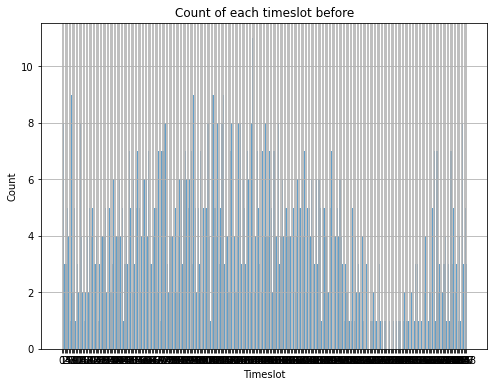

In [39]:
import matplotlib.pyplot as plt

original_slots = [req[1] for req in flight_requests]
# Count occurrences of each slot number
slot_counts = np.bincount(original_slots)

# Create x-axis values (timeslots)
timeslots = np.arange(len(slot_counts))

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.bar(timeslots, slot_counts, align='center', alpha=0.7)
plt.xticks(timeslots)
plt.xlabel('Timeslot')
plt.ylabel('Count')
plt.title('Count of each timeslot before')
plt.grid(True)
plt.show()

In [ ]:
new_slots = [slot for req,slot in updated_slots]
# Count occurrences of each slot number
slot_counts = np.bincount(new_slots)

# Create x-axis values (timeslots)
timeslots = np.arange(len(slot_counts))

# Plotting the graph
plt.figure(figsize=(8, 6))
plt.bar(timeslots, slot_counts, align='center', alpha=0.7)
plt.xticks(timeslots)
plt.xlabel('Timeslot')
plt.ylabel('Count')
plt.title('Count of each timeslot before')
plt.grid(True)
plt.show()